In [2]:
! pip install torch

     |████████████████████████████████| 753.2 MB 7.0 kB/s  eta 0:00:01     |█████████████████████████▎      | 594.2 MB 91.2 MB/s eta 0:00:02


In [3]:
! pip install torchvision==0.1.8

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time
# For progress visualization
from tqdm.notebook import tqdm
# For mixed-precision training
from apex import amp

from matplotlib.image import imread
from pathlib import Path
import glob
from PIL import Image

from sklearn.metrics import r2_score
from torch.utils.data import Dataset, DataLoader

from IPython.display import Image, display

In [2]:
use_gpu = torch.cuda.is_available()

# Download and unzip data

In [7]:
# Download and unzip (use validation set first)
!wget http://data.csail.mit.edu/places/places365/val_256.tar

--2020-06-18 19:09:53--  http://data.csail.mit.edu/places/places365/val_256.tar
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 525158400 (501M) [application/octet-stream]
Saving to: ‘val_256.tar’

val_256.tar         100%[===================>] 500.83M  7.44MB/s    in 7m 44s  

2020-06-18 19:17:38 (1.08 MB/s) - ‘val_256.tar’ saved [525158400/525158400]



In [3]:
!tar -xvf val_256.tar

val_256/
val_256/Places365_val_00035900.jpg
val_256/Places365_val_00035572.jpg
val_256/Places365_val_00002949.jpg
val_256/Places365_val_00007265.jpg
val_256/Places365_val_00019005.jpg
val_256/Places365_val_00027775.jpg
val_256/Places365_val_00015062.jpg
val_256/Places365_val_00014185.jpg
val_256/Places365_val_00026692.jpg
val_256/Places365_val_00006857.jpg
val_256/Places365_val_00006425.jpg
val_256/Places365_val_00034332.jpg
val_256/Places365_val_00014622.jpg
val_256/Places365_val_00026135.jpg
val_256/Places365_val_00018645.jpg
val_256/Places365_val_00006382.jpg
val_256/Places365_val_00034495.jpg
val_256/Places365_val_00017090.jpg
val_256/Places365_val_00009925.jpg
val_256/Places365_val_00009557.jpg
val_256/Places365_val_00025787.jpg
val_256/Places365_val_00005530.jpg
val_256/Places365_val_00005942.jpg
val_256/Places365_val_00032579.jpg
val_256/Places365_val_00017737.jpg
val_256/Places365_val_00025020.jpg
val_256/Places365_val_00012069.jpg
val_256/Places365_val_00005297.jpg
val_256/Pla

val_256/Places365_val_00035662.jpg
val_256/Places365_val_00007175.jpg
val_256/Places365_val_00027817.jpg
val_256/Places365_val_00027465.jpg
val_256/Places365_val_00015372.jpg
val_256/Places365_val_00019315.jpg
val_256/Places365_val_00029091.jpg
val_256/Places365_val_00005241.jpg
val_256/Places365_val_00032208.jpg
val_256/Places365_val_00009226.jpg
val_256/Places365_val_00029736.jpg
val_256/Places365_val_00005994.jpg
val_256/Places365_val_00025751.jpg
val_256/Places365_val_00012718.jpg
val_256/Places365_val_00009581.jpg
val_256/Places365_val_00017046.jpg
val_256/Places365_val_00008466.jpg
val_256/Places365_val_00008814.jpg
val_256/Places365_val_00033448.jpg
val_256/Places365_val_00004873.jpg
val_256/Places365_val_00004401.jpg
val_256/Places365_val_00036316.jpg
val_256/Places365_val_00016606.jpg
val_256/Places365_val_00013158.jpg
val_256/Places365_val_00024111.jpg
val_256/Places365_val_00028176.jpg
val_256/Places365_val_00007514.jpg
val_256/Places365_val_00007966.jpg
val_256/Places365_va

val_256/Places365_val_00006457.jpg
val_256/Places365_val_00018190.jpg
val_256/Places365_val_00003309.jpg
val_256/Places365_val_00034340.jpg
val_256/Places365_val_00027707.jpg
val_256/Places365_val_00015010.jpg
val_256/Places365_val_00022059.jpg
val_256/Places365_val_00019077.jpg
val_256/Places365_val_00035972.jpg
val_256/Places365_val_00035500.jpg
val_256/Places365_val_00002549.jpg
val_256/Places365_val_00007217.jpg
val_256/Places365_val_00024612.jpg
val_256/Places365_val_00016105.jpg
val_256/Places365_val_00028675.jpg
val_256/Places365_val_00008365.jpg
val_256/Places365_val_00036415.jpg
val_256/Places365_val_00004302.jpg
val_256/Places365_val_00029035.jpg
val_256/Places365_val_00009282.jpg
val_256/Places365_val_00017745.jpg
val_256/Places365_val_00025052.jpg
val_256/Places365_val_00005542.jpg
val_256/Places365_val_00005930.jpg
val_256/Places365_val_00032979.jpg
val_256/Places365_val_00029792.jpg
val_256/Places365_val_00009957.jpg
val_256/Places365_val_00009525.jpg
val_256/Places365_va

val_256/Places365_val_00010990.jpg
val_256/Places365_val_00020666.jpg
val_256/Places365_val_00012171.jpg
val_256/Places365_val_00025138.jpg
val_256/Places365_val_00017188.jpg
val_256/Places365_val_00032813.jpg
val_256/Places365_val_00032461.jpg
val_256/Places365_val_00005428.jpg
val_256/Places365_val_00000376.jpg
val_256/Places365_val_00001291.jpg
val_256/Places365_val_00033586.jpg
val_256/Places365_val_00024778.jpg
val_256/Places365_val_00013731.jpg
val_256/Places365_val_00021026.jpg
val_256/Places365_val_00001944.jpg
val_256/Places365_val_00001536.jpg
val_256/Places365_val_00004268.jpg
val_256/Places365_val_00033221.jpg
val_256/Places365_val_00013096.jpg
val_256/Places365_val_00021781.jpg
val_256/Places365_val_00002384.jpg
val_256/Places365_val_00030493.jpg
val_256/Places365_val_00010624.jpg
val_256/Places365_val_00022133.jpg
val_256/Places365_val_00002423.jpg
val_256/Places365_val_00002851.jpg
val_256/Places365_val_00035818.jpg
val_256/Places365_val_00030334.jpg
val_256/Places365_va

val_256/Places365_val_00022309.jpg
val_256/Places365_val_00027457.jpg
val_256/Places365_val_00027825.jpg
val_256/Places365_val_00003059.jpg
val_256/Places365_val_00034010.jpg
val_256/Places365_val_00006707.jpg
val_256/Places365_val_00026217.jpg
val_256/Places365_val_00023549.jpg
val_256/Places365_val_00014500.jpg
val_256/Places365_val_00014972.jpg
val_256/Places365_val_00018915.jpg
val_256/Places365_val_00018567.jpg
val_256/Places365_val_00003088.jpg
val_256/Places365_val_00018211.jpg
val_256/Places365_val_00026561.jpg
val_256/Places365_val_00026913.jpg
val_256/Places365_val_00011528.jpg
val_256/Places365_val_00014276.jpg
val_256/Places365_val_00034766.jpg
val_256/Places365_val_00006071.jpg
val_256/Places365_val_00031038.jpg
val_256/Places365_val_00023598.jpg
val_256/Places365_val_00015436.jpg
val_256/Places365_val_00015844.jpg
val_256/Places365_val_00010368.jpg
val_256/Places365_val_00027321.jpg
val_256/Places365_val_00007196.jpg
val_256/Places365_val_00019823.jpg
val_256/Places365_va

val_256/Places365_val_00029769.jpg
val_256/Places365_val_00031342.jpg
val_256/Places365_val_00003827.jpg
val_256/Places365_val_00003455.jpg
val_256/Places365_val_00023145.jpg
val_256/Places365_val_00011652.jpg
val_256/Places365_val_00031897.jpg
val_256/Places365_val_00002215.jpg
val_256/Places365_val_00007939.jpg
val_256/Places365_val_00030970.jpg
val_256/Places365_val_00030502.jpg
val_256/Places365_val_00035989.jpg
val_256/Places365_val_00010012.jpg
val_256/Places365_val_00022705.jpg
val_256/Places365_val_00012481.jpg
val_256/Places365_val_00020396.jpg
val_256/Places365_val_00009618.jpg
val_256/Places365_val_00000121.jpg
val_256/Places365_val_00032636.jpg
val_256/Places365_val_00012326.jpg
val_256/Places365_val_00020843.jpg
val_256/Places365_val_00020431.jpg
val_256/Places365_val_00017478.jpg
val_256/Places365_val_00029308.jpg
val_256/Places365_val_00000686.jpg
val_256/Places365_val_00032191.jpg
val_256/Places365_val_00033076.jpg
val_256/Places365_val_00001761.jpg
val_256/Places365_va

val_256/Places365_val_00009422.jpg
val_256/Places365_val_00009850.jpg
val_256/Places365_val_00005837.jpg
val_256/Places365_val_00005445.jpg
val_256/Places365_val_00029695.jpg
val_256/Places365_val_00028772.jpg
val_256/Places365_val_00033999.jpg
val_256/Places365_val_00024715.jpg
val_256/Places365_val_00016002.jpg
val_256/Places365_val_00001929.jpg
val_256/Places365_val_00004205.jpg
val_256/Places365_val_00008262.jpg
val_256/Places365_val_00019170.jpg
val_256/Places365_val_00027600.jpg
val_256/Places365_val_00010649.jpg
val_256/Places365_val_00015117.jpg
val_256/Places365_val_00035407.jpg
val_256/Places365_val_00035875.jpg
val_256/Places365_val_00007310.jpg
val_256/Places365_val_00030359.jpg
val_256/Places365_val_00014757.jpg
val_256/Places365_val_00011009.jpg
val_256/Places365_val_00026040.jpg
val_256/Places365_val_00018730.jpg
val_256/Places365_val_00034992.jpg
val_256/Places365_val_00031519.jpg
val_256/Places365_val_00018097.jpg
val_256/Places365_val_00006550.jpg
val_256/Places365_va

val_256/Places365_val_00008769.jpg
val_256/Places365_val_00013982.jpg
val_256/Places365_val_00033747.jpg
val_256/Places365_val_00001050.jpg
val_256/Places365_val_00036019.jpg
val_256/Places365_val_00034209.jpg
val_256/Places365_val_00003240.jpg
val_256/Places365_val_00031557.jpg
val_256/Places365_val_00031925.jpg
val_256/Places365_val_00003995.jpg
val_256/Places365_val_00011047.jpg
val_256/Places365_val_00014719.jpg
val_256/Places365_val_00023750.jpg
val_256/Places365_val_00030317.jpg
val_256/Places365_val_00019699.jpg
val_256/Places365_val_00002400.jpg
val_256/Places365_val_00002872.jpg
val_256/Places365_val_00035449.jpg
val_256/Places365_val_00022110.jpg
val_256/Places365_val_00015159.jpg
val_256/Places365_val_00010607.jpg
val_256/Places365_val_00033202.jpg
val_256/Places365_val_00001967.jpg
val_256/Places365_val_00001515.jpg
val_256/Places365_val_00021005.jpg
val_256/Places365_val_00013712.jpg
val_256/Places365_val_00000355.jpg
val_256/Places365_val_00032830.jpg
val_256/Places365_va

val_256/Places365_val_00013554.jpg
val_256/Places365_val_00013926.jpg
val_256/Places365_val_00021243.jpg
val_256/Places365_val_00028908.jpg
val_256/Places365_val_00032604.jpg
val_256/Places365_val_00000113.jpg
val_256/Places365_val_00025888.jpg
val_256/Places365_val_00017838.jpg
val_256/Places365_val_00020403.jpg
val_256/Places365_val_00020871.jpg
val_256/Places365_val_00012314.jpg
val_256/Places365_val_00031711.jpg
val_256/Places365_val_00006758.jpg
val_256/Places365_val_00003006.jpg
val_256/Places365_val_00018538.jpg
val_256/Places365_val_00023964.jpg
val_256/Places365_val_00023516.jpg
val_256/Places365_val_00011201.jpg
val_256/Places365_val_00026248.jpg
val_256/Places365_val_00022883.jpg
val_256/Places365_val_00002646.jpg
val_256/Places365_val_00007118.jpg
val_256/Places365_val_00030151.jpg
val_256/Places365_val_00027408.jpg
val_256/Places365_val_00010833.jpg
val_256/Places365_val_00010441.jpg
val_256/Places365_val_00022356.jpg
val_256/Places365_val_00019378.jpg
val_256/Places365_va

val_256/Places365_val_00027456.jpg
val_256/Places365_val_00027824.jpg
val_256/Places365_val_00019326.jpg
val_256/Places365_val_00015894.jpg
val_256/Places365_val_00007146.jpg
val_256/Places365_val_00019481.jpg
val_256/Places365_val_00002618.jpg
val_256/Places365_val_00035651.jpg
val_256/Places365_val_00018914.jpg
val_256/Places365_val_00018566.jpg
val_256/Places365_val_00026216.jpg
val_256/Places365_val_00014501.jpg
val_256/Places365_val_00014973.jpg
val_256/Places365_val_00023548.jpg
val_256/Places365_val_00034011.jpg
val_256/Places365_val_00003058.jpg
val_256/Places365_val_00006706.jpg
val_256/Places365_val_00029364.jpg
val_256/Places365_val_00025303.jpg
val_256/Places365_val_00017866.jpg
val_256/Places365_val_00017414.jpg
val_256/Places365_val_00005613.jpg
val_256/Places365_val_00009674.jpg
val_256/Places365_val_00008793.jpg
val_256/Places365_val_00016254.jpg
val_256/Places365_val_00024931.jpg
val_256/Places365_val_00024543.jpg
val_256/Places365_val_00013978.jpg
val_256/Places365_va

val_256/Places365_val_00030347.jpg
val_256/Places365_val_00033987.jpg
val_256/Places365_val_00013742.jpg
val_256/Places365_val_00021055.jpg
val_256/Places365_val_00001937.jpg
val_256/Places365_val_00001545.jpg
val_256/Places365_val_00033252.jpg
val_256/Places365_val_00020615.jpg
val_256/Places365_val_00012102.jpg
val_256/Places365_val_00005829.jpg
val_256/Places365_val_00032860.jpg
val_256/Places365_val_00032412.jpg
val_256/Places365_val_00000305.jpg
val_256/Places365_val_00032364.jpg
val_256/Places365_val_00000801.jpg
val_256/Places365_val_00000473.jpg
val_256/Places365_val_00020163.jpg
val_256/Places365_val_00012674.jpg
val_256/Places365_val_00013793.jpg
val_256/Places365_val_00021084.jpg
val_256/Places365_val_00008978.jpg
val_256/Places365_val_00001233.jpg
val_256/Places365_val_00033956.jpg
val_256/Places365_val_00033524.jpg
val_256/Places365_val_00013034.jpg
val_256/Places365_val_00021723.jpg
val_256/Places365_val_00001594.jpg
val_256/Places365_val_00033283.jpg
val_256/Places365_va

val_256/Places365_val_00024992.jpg
val_256/Places365_val_00004757.jpg
val_256/Places365_val_00001009.jpg
val_256/Places365_val_00028587.jpg
val_256/Places365_val_00036040.jpg
val_256/Places365_val_00015445.jpg
val_256/Places365_val_00015837.jpg
val_256/Places365_val_00027352.jpg
val_256/Places365_val_00019850.jpg
val_256/Places365_val_00019422.jpg
val_256/Places365_val_00027887.jpg
val_256/Places365_val_00007642.jpg
val_256/Places365_val_00019385.jpg
val_256/Places365_val_00035155.jpg
val_256/Places365_val_00018262.jpg
val_256/Places365_val_00011929.jpg
val_256/Places365_val_00026512.jpg
val_256/Places365_val_00026960.jpg
val_256/Places365_val_00014205.jpg
val_256/Places365_val_00034715.jpg
val_256/Places365_val_00006002.jpg
val_256/Places365_val_00023999.jpg
val_256/Places365_val_00024626.jpg
val_256/Places365_val_00016131.jpg
val_256/Places365_val_00021178.jpg
val_256/Places365_val_00008884.jpg
val_256/Places365_val_00028641.jpg
val_256/Places365_val_00036386.jpg
val_256/Places365_va

val_256/Places365_val_00004989.jpg
val_256/Places365_val_00013705.jpg
val_256/Places365_val_00021012.jpg
val_256/Places365_val_00001970.jpg
val_256/Places365_val_00001502.jpg
val_256/Places365_val_00033215.jpg
val_256/Places365_val_00026478.jpg
val_256/Places365_val_00011843.jpg
val_256/Places365_val_00011431.jpg
val_256/Places365_val_00023326.jpg
val_256/Places365_val_00003191.jpg
val_256/Places365_val_00018308.jpg
val_256/Places365_val_00031686.jpg
val_256/Places365_val_00011396.jpg
val_256/Places365_val_00023481.jpg
val_256/Places365_val_00003636.jpg
val_256/Places365_val_00006168.jpg
val_256/Places365_val_00031121.jpg
val_256/Places365_val_00019548.jpg
val_256/Places365_val_00035798.jpg
val_256/Places365_val_00022914.jpg
val_256/Places365_val_00022566.jpg
val_256/Places365_val_00010271.jpg
val_256/Places365_val_00027238.jpg
val_256/Places365_val_00030761.jpg
val_256/Places365_val_00007728.jpg
val_256/Places365_val_00002076.jpg
val_256/Places365_val_00015288.jpg
val_256/Places365_va

val_256/Places365_val_00021228.jpg
val_256/Places365_val_00024904.jpg
val_256/Places365_val_00024576.jpg
val_256/Places365_val_00018695.jpg
val_256/Places365_val_00006352.jpg
val_256/Places365_val_00034837.jpg
val_256/Places365_val_00034445.jpg
val_256/Places365_val_00014155.jpg
val_256/Places365_val_00026642.jpg
val_256/Places365_val_00006887.jpg
val_256/Places365_val_00018132.jpg
val_256/Places365_val_00035205.jpg
val_256/Places365_val_00007960.jpg
val_256/Places365_val_00007512.jpg
val_256/Places365_val_00030929.jpg
val_256/Places365_val_00002999.jpg
val_256/Places365_val_00019772.jpg
val_256/Places365_val_00027002.jpg
val_256/Places365_val_00015715.jpg
val_256/Places365_val_00001359.jpg
val_256/Places365_val_00036310.jpg
val_256/Places365_val_00004407.jpg
val_256/Places365_val_00004875.jpg
val_256/Places365_val_00008812.jpg
val_256/Places365_val_00008460.jpg
val_256/Places365_val_00028170.jpg
val_256/Places365_val_00024117.jpg
val_256/Places365_val_00021649.jpg
val_256/Places365_va

val_256/Places365_val_00002691.jpg
val_256/Places365_val_00022381.jpg
val_256/Places365_val_00010496.jpg
val_256/Places365_val_00030621.jpg
val_256/Places365_val_00007668.jpg
val_256/Places365_val_00002136.jpg
val_256/Places365_val_00006516.jpg
val_256/Places365_val_00006964.jpg
val_256/Places365_val_00034201.jpg
val_256/Places365_val_00003248.jpg
val_256/Places365_val_00018776.jpg
val_256/Places365_val_00014711.jpg
val_256/Places365_val_00023758.jpg
val_256/Places365_val_00026006.jpg
val_256/Places365_val_00002408.jpg
val_256/Places365_val_00035441.jpg
val_256/Places365_val_00035833.jpg
val_256/Places365_val_00007356.jpg
val_256/Places365_val_00019691.jpg
val_256/Places365_val_00027646.jpg
val_256/Places365_val_00022118.jpg
val_256/Places365_val_00015151.jpg
val_256/Places365_val_00019136.jpg
val_256/Places365_val_00007883.jpg
val_256/Places365_val_00008224.jpg
val_256/Places365_val_00028093.jpg
val_256/Places365_val_00004243.jpg
val_256/Places365_val_00024753.jpg
val_256/Places365_va

val_256/Places365_val_00015655.jpg
val_256/Places365_val_00035890.jpg
val_256/Places365_val_00019632.jpg
val_256/Places365_val_00010395.jpg
val_256/Places365_val_00022482.jpg
val_256/Places365_val_00002635.jpg
val_256/Places365_val_00030122.jpg
val_256/Places365_val_00010840.jpg
val_256/Places365_val_00010432.jpg
val_256/Places365_val_00027809.jpg
val_256/Places365_val_00022325.jpg
val_256/Places365_val_00002192.jpg
val_256/Places365_val_00030685.jpg
val_256/Places365_val_00031762.jpg
val_256/Places365_val_00003075.jpg
val_256/Places365_val_00018939.jpg
val_256/Places365_val_00023917.jpg
val_256/Places365_val_00023565.jpg
val_256/Places365_val_00011272.jpg
val_256/Places365_val_00032677.jpg
val_256/Places365_val_00000160.jpg
val_256/Places365_val_00009659.jpg
val_256/Places365_val_00025489.jpg
val_256/Places365_val_00005199.jpg
val_256/Places365_val_00029349.jpg
val_256/Places365_val_00020470.jpg
val_256/Places365_val_00020802.jpg
val_256/Places365_val_00017439.jpg
val_256/Places365_va

val_256/Places365_val_00011364.jpg
val_256/Places365_val_00031674.jpg
val_256/Places365_val_00003163.jpg
val_256/Places365_val_00002084.jpg
val_256/Places365_val_00030793.jpg
val_256/Places365_val_00010956.jpg
val_256/Places365_val_00010524.jpg
val_256/Places365_val_00022233.jpg
val_256/Places365_val_00002723.jpg
val_256/Places365_val_00030034.jpg
val_256/Places365_val_00010283.jpg
val_256/Places365_val_00022594.jpg
val_256/Places365_val_00001191.jpg
val_256/Places365_val_00033686.jpg
val_256/Places365_val_00013431.jpg
val_256/Places365_val_00013843.jpg
val_256/Places365_val_00024478.jpg
val_256/Places365_val_00021326.jpg
val_256/Places365_val_00001636.jpg
val_256/Places365_val_00033121.jpg
val_256/Places365_val_00004168.jpg
val_256/Places365_val_00013396.jpg
val_256/Places365_val_00021481.jpg
val_256/Places365_val_00020566.jpg
val_256/Places365_val_00020914.jpg
val_256/Places365_val_00025238.jpg
val_256/Places365_val_00012271.jpg
val_256/Places365_val_00017288.jpg
val_256/Places365_va

val_256/Places365_val_00026978.jpg
val_256/Places365_val_00023981.jpg
val_256/Places365_val_00031053.jpg
val_256/Places365_val_00003744.jpg
val_256/Places365_val_00004489.jpg
val_256/Places365_val_00028659.jpg
val_256/Places365_val_00016129.jpg
val_256/Places365_val_00021160.jpg
val_256/Places365_val_00013677.jpg
val_256/Places365_val_00033367.jpg
val_256/Places365_val_00036439.jpg
val_256/Places365_val_00001802.jpg
val_256/Places365_val_00001470.jpg
val_256/Places365_val_00008349.jpg
val_256/Places365_val_00024199.jpg
val_256/Places365_val_00012037.jpg
val_256/Places365_val_00020720.jpg
val_256/Places365_val_00017769.jpg
val_256/Places365_val_00000597.jpg
val_256/Places365_val_00029019.jpg
val_256/Places365_val_00032280.jpg
val_256/Places365_val_00012790.jpg
val_256/Places365_val_00009509.jpg
val_256/Places365_val_00020087.jpg
val_256/Places365_val_00000230.jpg
val_256/Places365_val_00032955.jpg
val_256/Places365_val_00032527.jpg
val_256/Places365_val_00011122.jpg
val_256/Places365_va

val_256/Places365_val_00007093.jpg
val_256/Places365_val_00027224.jpg
val_256/Places365_val_00022908.jpg
val_256/Places365_val_00015533.jpg
val_256/Places365_val_00015941.jpg
val_256/Places365_val_00009815.jpg
val_256/Places365_val_00009467.jpg
val_256/Places365_val_00005400.jpg
val_256/Places365_val_00005872.jpg
val_256/Places365_val_00032449.jpg
val_256/Places365_val_00025110.jpg
val_256/Places365_val_00012159.jpg
val_256/Places365_val_00017607.jpg
val_256/Places365_val_00029177.jpg
val_256/Places365_val_00033209.jpg
val_256/Places365_val_00004240.jpg
val_256/Places365_val_00028090.jpg
val_256/Places365_val_00008227.jpg
val_256/Places365_val_00004995.jpg
val_256/Places365_val_00028737.jpg
val_256/Places365_val_00016047.jpg
val_256/Places365_val_00008580.jpg
val_256/Places365_val_00013719.jpg
val_256/Places365_val_00024750.jpg
val_256/Places365_val_00019692.jpg
val_256/Places365_val_00007355.jpg
val_256/Places365_val_00035830.jpg
val_256/Places365_val_00035442.jpg
val_256/Places365_va

val_256/Places365_val_00032601.jpg
val_256/Places365_val_00005648.jpg
val_256/Places365_val_00029498.jpg
val_256/Places365_val_00000116.jpg
val_256/Places365_val_00020406.jpg
val_256/Places365_val_00009188.jpg
val_256/Places365_val_00020874.jpg
val_256/Places365_val_00012311.jpg
val_256/Places365_val_00025358.jpg
val_256/Places365_val_00031714.jpg
val_256/Places365_val_00003003.jpg
val_256/Places365_val_00026998.jpg
val_256/Places365_val_00014928.jpg
val_256/Places365_val_00023961.jpg
val_256/Places365_val_00023513.jpg
val_256/Places365_val_00011204.jpg
val_256/Places365_val_00022886.jpg
val_256/Places365_val_00002643.jpg
val_256/Places365_val_00030154.jpg
val_256/Places365_val_00010836.jpg
val_256/Places365_val_00010444.jpg
val_256/Places365_val_00022353.jpg
val_256/Places365_val_00002692.jpg
val_256/Places365_val_00019879.jpg
val_256/Places365_val_00030185.jpg
val_256/Places365_val_00010332.jpg
val_256/Places365_val_00022857.jpg
val_256/Places365_val_00022425.jpg
val_256/Places365_va

val_256/Places365_val_00034270.jpg
val_256/Places365_val_00006915.jpg
val_256/Places365_val_00006567.jpg
val_256/Places365_val_00011799.jpg
val_256/Places365_val_00015120.jpg
val_256/Places365_val_00022169.jpg
val_256/Places365_val_00027637.jpg
val_256/Places365_val_00007480.jpg
val_256/Places365_val_00019147.jpg
val_256/Places365_val_00035397.jpg
val_256/Places365_val_00015687.jpg
val_256/Places365_val_00027190.jpg
val_256/Places365_val_00007327.jpg
val_256/Places365_val_00035842.jpg
val_256/Places365_val_00035430.jpg
val_256/Places365_val_00002479.jpg
val_256/Places365_val_00019196.jpg
val_256/Places365_val_00030418.jpg
val_256/Places365_val_00007823.jpg
val_256/Places365_val_00007451.jpg
val_256/Places365_val_00035346.jpg
val_256/Places365_val_00019631.jpg
val_256/Places365_val_00035893.jpg
val_256/Places365_val_00015656.jpg
val_256/Places365_val_00010108.jpg
val_256/Places365_val_00027141.jpg
val_256/Places365_val_00034974.jpg
val_256/Places365_val_00034506.jpg
val_256/Places365_va

val_256/Places365_val_00032130.jpg
val_256/Places365_val_00000627.jpg
val_256/Places365_val_00032646.jpg
val_256/Places365_val_00000151.jpg
val_256/Places365_val_00009668.jpg
val_256/Places365_val_00012883.jpg
val_256/Places365_val_00029378.jpg
val_256/Places365_val_00020441.jpg
val_256/Places365_val_00020833.jpg
val_256/Places365_val_00017408.jpg
val_256/Places365_val_00012356.jpg
val_256/Places365_val_00008028.jpg
val_256/Places365_val_00001711.jpg
val_256/Places365_val_00033006.jpg
val_256/Places365_val_00013516.jpg
val_256/Places365_val_00013964.jpg
val_256/Places365_val_00016248.jpg
val_256/Places365_val_00021201.jpg
val_256/Places365_val_00028538.jpg
val_256/Places365_val_00015888.jpg
val_256/Places365_val_00002604.jpg
val_256/Places365_val_00030113.jpg
val_256/Places365_val_00010871.jpg
val_256/Places365_val_00010403.jpg
val_256/Places365_val_00027838.jpg
val_256/Places365_val_00022314.jpg
val_256/Places365_val_00031753.jpg
val_256/Places365_val_00003044.jpg
val_256/Places365_va

val_256/Places365_val_00001959.jpg
val_256/Places365_val_00015167.jpg
val_256/Places365_val_00027670.jpg
val_256/Places365_val_00010639.jpg
val_256/Places365_val_00019100.jpg
val_256/Places365_val_00002399.jpg
val_256/Places365_val_00022689.jpg
val_256/Places365_val_00007360.jpg
val_256/Places365_val_00030329.jpg
val_256/Places365_val_00035805.jpg
val_256/Places365_val_00035477.jpg
val_256/Places365_val_00034590.jpg
val_256/Places365_val_00006287.jpg
val_256/Places365_val_00018740.jpg
val_256/Places365_val_00011079.jpg
val_256/Places365_val_00026030.jpg
val_256/Places365_val_00014727.jpg
val_256/Places365_val_00034237.jpg
val_256/Places365_val_00031569.jpg
val_256/Places365_val_00006952.jpg
val_256/Places365_val_00006520.jpg
val_256/Places365_val_00026797.jpg
val_256/Places365_val_00014080.jpg
val_256/Places365_val_00024304.jpg
val_256/Places365_val_00016861.jpg
val_256/Places365_val_00016413.jpg
val_256/Places365_val_00021828.jpg
val_256/Places365_val_00028363.jpg
val_256/Places365_va

val_256/Places365_val_00030395.jpg
val_256/Places365_val_00002482.jpg
val_256/Places365_val_00022635.jpg
val_256/Places365_val_00010122.jpg
val_256/Places365_val_00033527.jpg
val_256/Places365_val_00033955.jpg
val_256/Places365_val_00001230.jpg
val_256/Places365_val_00036279.jpg
val_256/Places365_val_00021087.jpg
val_256/Places365_val_00008509.jpg
val_256/Places365_val_00013790.jpg
val_256/Places365_val_00033280.jpg
val_256/Places365_val_00028019.jpg
val_256/Places365_val_00001597.jpg
val_256/Places365_val_00021720.jpg
val_256/Places365_val_00016769.jpg
val_256/Places365_val_00013037.jpg
val_256/Places365_val_00025199.jpg
val_256/Places365_val_00009349.jpg
val_256/Places365_val_00000470.jpg
val_256/Places365_val_00000802.jpg
val_256/Places365_val_00032367.jpg
val_256/Places365_val_00012677.jpg
val_256/Places365_val_00017129.jpg
val_256/Places365_val_00020160.jpg
val_256/Places365_val_00029659.jpg
val_256/Places365_val_00005489.jpg
val_256/Places365_val_00028955.jpg
val_256/Places365_va

val_256/Places365_val_00028642.jpg
val_256/Places365_val_00008887.jpg
val_256/Places365_val_00016132.jpg
val_256/Places365_val_00024625.jpg
val_256/Places365_val_00004335.jpg
val_256/Places365_val_00001819.jpg
val_256/Places365_val_00036422.jpg
val_256/Places365_val_00016695.jpg
val_256/Places365_val_00008352.jpg
val_256/Places365_val_00024182.jpg
val_256/Places365_val_00014206.jpg
val_256/Places365_val_00026963.jpg
val_256/Places365_val_00026511.jpg
val_256/Places365_val_00011558.jpg
val_256/Places365_val_00018261.jpg
val_256/Places365_val_00006001.jpg
val_256/Places365_val_00031048.jpg
val_256/Places365_val_00034716.jpg
val_256/Places365_val_00019421.jpg
val_256/Places365_val_00019853.jpg
val_256/Places365_val_00010318.jpg
val_256/Places365_val_00027351.jpg
val_256/Places365_val_00015834.jpg
val_256/Places365_val_00015446.jpg
val_256/Places365_val_00035156.jpg
val_256/Places365_val_00030608.jpg
val_256/Places365_val_00019386.jpg
val_256/Places365_val_00007641.jpg
val_256/Places365_va

val_256/Places365_val_00020651.jpg
val_256/Places365_val_00017618.jpg
val_256/Places365_val_00000341.jpg
val_256/Places365_val_00032456.jpg
val_256/Places365_val_00032824.jpg
val_256/Places365_val_00009478.jpg
val_256/Places365_val_00003981.jpg
val_256/Places365_val_00011053.jpg
val_256/Places365_val_00023744.jpg
val_256/Places365_val_00003254.jpg
val_256/Places365_val_00006978.jpg
val_256/Places365_val_00031931.jpg
val_256/Places365_val_00031543.jpg
val_256/Places365_val_00022104.jpg
val_256/Places365_val_00010613.jpg
val_256/Places365_val_00030303.jpg
val_256/Places365_val_00002866.jpg
val_256/Places365_val_00002414.jpg
val_256/Places365_val_00000604.jpg
val_256/Places365_val_00032113.jpg
val_256/Places365_val_00017888.jpg
val_256/Places365_val_00025838.jpg
val_256/Places365_val_00012403.jpg
val_256/Places365_val_00012871.jpg
val_256/Places365_val_00020314.jpg
val_256/Places365_val_00013996.jpg
val_256/Places365_val_00033753.jpg
val_256/Places365_val_00001044.jpg
val_256/Places365_va

val_256/Places365_val_00026220.jpg
val_256/Places365_val_00022499.jpg
val_256/Places365_val_00035667.jpg
val_256/Places365_val_00007170.jpg
val_256/Places365_val_00030139.jpg
val_256/Places365_val_00027812.jpg
val_256/Places365_val_00027460.jpg
val_256/Places365_val_00010429.jpg
val_256/Places365_val_00015377.jpg
val_256/Places365_val_00002189.jpg
val_256/Places365_val_00019310.jpg
val_256/Places365_val_00002317.jpg
val_256/Places365_val_00030400.jpg
val_256/Places365_val_00030872.jpg
val_256/Places365_val_00007449.jpg
val_256/Places365_val_00010110.jpg
val_256/Places365_val_00027159.jpg
val_256/Places365_val_00022607.jpg
val_256/Places365_val_00019629.jpg
val_256/Places365_val_00006209.jpg
val_256/Places365_val_00031240.jpg
val_256/Places365_val_00003557.jpg
val_256/Places365_val_00003925.jpg
val_256/Places365_val_00018069.jpg
val_256/Places365_val_00031995.jpg
val_256/Places365_val_00023047.jpg
val_256/Places365_val_00026719.jpg
val_256/Places365_val_00011750.jpg
val_256/Places365_va

val_256/Places365_val_00028866.jpg
val_256/Places365_val_00008104.jpg
val_256/Places365_val_00004163.jpg
val_256/Places365_val_00027566.jpg
val_256/Places365_val_00027914.jpg
val_256/Places365_val_00022238.jpg
val_256/Places365_val_00015271.jpg
val_256/Places365_val_00030798.jpg
val_256/Places365_val_00019216.jpg
val_256/Places365_val_00010288.jpg
val_256/Places365_val_00002728.jpg
val_256/Places365_val_00035761.jpg
val_256/Places365_val_00007076.jpg
val_256/Places365_val_00006191.jpg
val_256/Places365_val_00018824.jpg
val_256/Places365_val_00018456.jpg
val_256/Places365_val_00034686.jpg
val_256/Places365_val_00014431.jpg
val_256/Places365_val_00014843.jpg
val_256/Places365_val_00023478.jpg
val_256/Places365_val_00026326.jpg
val_256/Places365_val_00006636.jpg
val_256/Places365_val_00034121.jpg
val_256/Places365_val_00003168.jpg
val_256/Places365_val_00014396.jpg
val_256/Places365_val_00026481.jpg
val_256/Places365_val_00016705.jpg
val_256/Places365_val_00024012.jpg
val_256/Places365_va

val_256/Places365_val_00011680.jpg
val_256/Places365_val_00023197.jpg
val_256/Places365_val_00003320.jpg
val_256/Places365_val_00034369.jpg
val_256/Places365_val_00031437.jpg
val_256/Places365_val_00031845.jpg
val_256/Places365_val_00007599.jpg
val_256/Places365_val_00015039.jpg
val_256/Places365_val_00022070.jpg
val_256/Places365_val_00010767.jpg
val_256/Places365_val_00030277.jpg
val_256/Places365_val_00035529.jpg
val_256/Places365_val_00002560.jpg
val_256/Places365_val_00002912.jpg
val_256/Places365_val_00027089.jpg
val_256/Places365_val_00020344.jpg
val_256/Places365_val_00012453.jpg
val_256/Places365_val_00012821.jpg
val_256/Places365_val_00025868.jpg
val_256/Places365_val_00020891.jpg
val_256/Places365_val_00032143.jpg
val_256/Places365_val_00000654.jpg
val_256/Places365_val_00013213.jpg
val_256/Places365_val_00021504.jpg
val_256/Places365_val_00021976.jpg
val_256/Places365_val_00001014.jpg
val_256/Places365_val_00033703.jpg
val_256/Places365_val_00010306.jpg
val_256/Places365_va

val_256/Places365_val_00017137.jpg
val_256/Places365_val_00029647.jpg
val_256/Places365_val_00005497.jpg
val_256/Places365_val_00033539.jpg
val_256/Places365_val_00004570.jpg
val_256/Places365_val_00004902.jpg
val_256/Places365_val_00036267.jpg
val_256/Places365_val_00021099.jpg
val_256/Places365_val_00008965.jpg
val_256/Places365_val_00008517.jpg
val_256/Places365_val_00028007.jpg
val_256/Places365_val_00001589.jpg
val_256/Places365_val_00016777.jpg
val_256/Places365_val_00013029.jpg
val_256/Places365_val_00024060.jpg
val_256/Places365_val_00007817.jpg
val_256/Places365_val_00007465.jpg
val_256/Places365_val_00035372.jpg
val_256/Places365_val_00019605.jpg
val_256/Places365_val_00015662.jpg
val_256/Places365_val_00027175.jpg
val_256/Places365_val_00026092.jpg
val_256/Places365_val_00014785.jpg
val_256/Places365_val_00003909.jpg
val_256/Places365_val_00034940.jpg
val_256/Places365_val_00034532.jpg
val_256/Places365_val_00006225.jpg
val_256/Places365_val_00026735.jpg
val_256/Places365_va

val_256/Places365_val_00011277.jpg
val_256/Places365_val_00032672.jpg
val_256/Places365_val_00029899.jpg
val_256/Places365_val_00000165.jpg
val_256/Places365_val_00020475.jpg
val_256/Places365_val_00020807.jpg
val_256/Places365_val_00012362.jpg
val_256/Places365_val_00013285.jpg
val_256/Places365_val_00021592.jpg
val_256/Places365_val_00001725.jpg
val_256/Places365_val_00033032.jpg
val_256/Places365_val_00013522.jpg
val_256/Places365_val_00013950.jpg
val_256/Places365_val_00024919.jpg
val_256/Places365_val_00021235.jpg
val_256/Places365_val_00001082.jpg
val_256/Places365_val_00033795.jpg
val_256/Places365_val_00013254.jpg
val_256/Places365_val_00016978.jpg
val_256/Places365_val_00021543.jpg
val_256/Places365_val_00021931.jpg
val_256/Places365_val_00001053.jpg
val_256/Places365_val_00033744.jpg
val_256/Places365_val_00013981.jpg
val_256/Places365_val_00020303.jpg
val_256/Places365_val_00012414.jpg
val_256/Places365_val_00012866.jpg
val_256/Places365_val_00029848.jpg
val_256/Places365_va

val_256/Places365_val_00029176.jpg
val_256/Places365_val_00012158.jpg
val_256/Places365_val_00025111.jpg
val_256/Places365_val_00017606.jpg
val_256/Places365_val_00032448.jpg
val_256/Places365_val_00005401.jpg
val_256/Places365_val_00005873.jpg
val_256/Places365_val_00009814.jpg
val_256/Places365_val_00009466.jpg
val_256/Places365_val_00008581.jpg
val_256/Places365_val_00016046.jpg
val_256/Places365_val_00024751.jpg
val_256/Places365_val_00013718.jpg
val_256/Places365_val_00004994.jpg
val_256/Places365_val_00028736.jpg
val_256/Places365_val_00008226.jpg
val_256/Places365_val_00004241.jpg
val_256/Places365_val_00033208.jpg
val_256/Places365_val_00028091.jpg
val_256/Places365_val_00004537.jpg
val_256/Places365_val_00004945.jpg
val_256/Places365_val_00001269.jpg
val_256/Places365_val_00036220.jpg
val_256/Places365_val_00016097.jpg
val_256/Places365_val_00008922.jpg
val_256/Places365_val_00008550.jpg
val_256/Places365_val_00024780.jpg
val_256/Places365_val_00004290.jpg
val_256/Places365_va

val_256/Places365_val_00015699.jpg
val_256/Places365_val_00007339.jpg
val_256/Places365_val_00030370.jpg
val_256/Places365_val_00002815.jpg
val_256/Places365_val_00002467.jpg
val_256/Places365_val_00003580.jpg
val_256/Places365_val_00031297.jpg
val_256/Places365_val_00018719.jpg
val_256/Places365_val_00011020.jpg
val_256/Places365_val_00026069.jpg
val_256/Places365_val_00023737.jpg
val_256/Places365_val_00003227.jpg
val_256/Places365_val_00031942.jpg
val_256/Places365_val_00031530.jpg
val_256/Places365_val_00006579.jpg
val_256/Places365_val_00011787.jpg
val_256/Places365_val_00023090.jpg
val_256/Places365_val_00000495.jpg
val_256/Places365_val_00032382.jpg
val_256/Places365_val_00012135.jpg
val_256/Places365_val_00020622.jpg
val_256/Places365_val_00000332.jpg
val_256/Places365_val_00032425.jpg
val_256/Places365_val_00032857.jpg
val_256/Places365_val_00012692.jpg
val_256/Places365_val_00009879.jpg
val_256/Places365_val_00020185.jpg
val_256/Places365_val_00021062.jpg
val_256/Places365_va

val_256/Places365_val_00008700.jpg
val_256/Places365_val_00013599.jpg
val_256/Places365_val_00033089.jpg
val_256/Places365_val_00028210.jpg
val_256/Places365_val_00016912.jpg
val_256/Places365_val_00016560.jpg
val_256/Places365_val_00021529.jpg
val_256/Places365_val_00024277.jpg
val_256/Places365_val_00007672.jpg
val_256/Places365_val_00035165.jpg
val_256/Places365_val_00019860.jpg
val_256/Places365_val_00019412.jpg
val_256/Places365_val_00015475.jpg
val_256/Places365_val_00015807.jpg
val_256/Places365_val_00027362.jpg
val_256/Places365_val_00026285.jpg
val_256/Places365_val_00014592.jpg
val_256/Places365_val_00034725.jpg
val_256/Places365_val_00006032.jpg
val_256/Places365_val_00018987.jpg
val_256/Places365_val_00026522.jpg
val_256/Places365_val_00026950.jpg
val_256/Places365_val_00011919.jpg
val_256/Places365_val_00014235.jpg
val_256/Places365_val_00034082.jpg
val_256/Places365_val_00018252.jpg
val_256/Places365_val_00006795.jpg
val_256/Places365_val_00001458.jpg
val_256/Places365_va

val_256/Places365_val_00030562.jpg
val_256/Places365_val_00002275.jpg
val_256/Places365_val_00022765.jpg
val_256/Places365_val_00010072.jpg
val_256/Places365_val_00022013.jpg
val_256/Places365_val_00010704.jpg
val_256/Places365_val_00007988.jpg
val_256/Places365_val_00030214.jpg
val_256/Places365_val_00002971.jpg
val_256/Places365_val_00002503.jpg
val_256/Places365_val_00035938.jpg
val_256/Places365_val_00003896.jpg
val_256/Places365_val_00011144.jpg
val_256/Places365_val_00023653.jpg
val_256/Places365_val_00003343.jpg
val_256/Places365_val_00031826.jpg
val_256/Places365_val_00031454.jpg
val_256/Places365_val_00000983.jpg
val_256/Places365_val_00012051.jpg
val_256/Places365_val_00025018.jpg
val_256/Places365_val_00020746.jpg
val_256/Places365_val_00000256.jpg
val_256/Places365_val_00032541.jpg
val_256/Places365_val_00032933.jpg
val_256/Places365_val_00005508.jpg
val_256/Places365_val_00008488.jpg
val_256/Places365_val_00021106.jpg
val_256/Places365_val_00024658.jpg
val_256/Places365_va

val_256/Places365_val_00019429.jpg
val_256/Places365_val_00022875.jpg
val_256/Places365_val_00022407.jpg
val_256/Places365_val_00010310.jpg
val_256/Places365_val_00027359.jpg
val_256/Places365_val_00030600.jpg
val_256/Places365_val_00007649.jpg
val_256/Places365_val_00002117.jpg
val_256/Places365_val_00016929.jpg
val_256/Places365_val_00021512.jpg
val_256/Places365_val_00021960.jpg
val_256/Places365_val_00013205.jpg
val_256/Places365_val_00033715.jpg
val_256/Places365_val_00001002.jpg
val_256/Places365_val_00024999.jpg
val_256/Places365_val_00012445.jpg
val_256/Places365_val_00012837.jpg
val_256/Places365_val_00020352.jpg
val_256/Places365_val_00029819.jpg
val_256/Places365_val_00020887.jpg
val_256/Places365_val_00000642.jpg
val_256/Places365_val_00032155.jpg
val_256/Places365_val_00025135.jpg
val_256/Places365_val_00017622.jpg
val_256/Places365_val_00029152.jpg
val_256/Places365_val_00005382.jpg
val_256/Places365_val_00025692.jpg
val_256/Places365_val_00009442.jpg
val_256/Places365_va

In [4]:
import os
os.makedirs('images/train/class/', exist_ok=True) # 29,200 images
os.makedirs('images/val/class/', exist_ok=True)   #  7,300 images
for i, file in enumerate(os.listdir('val_256')):
    if i < 7300: # first 7300 will be val
        os.rename('val_256/' + file, 'images/val/class/' + file)
    else: # others will be train
        os.rename('val_256/' + file, 'images/train/class/' + file)

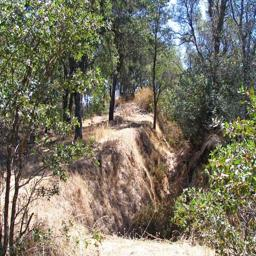

In [6]:
display(Image(filename='images/train/class/Places365_val_00018645.jpg'))

# Dataset

In [7]:
class ImageDataset(Dataset):
    def __init__(self, files):
        self.files = np.array(files)
        self.length = len(files)
    
    def __getitem__(self, idx):
        img = imread(self.files[idx])
        if img.shape == (256, 256, 3):  # if a color image
            img_lab = rgb2lab(img)
            img_lab = (img_lab + [0, 128, 128]) / [100, 255, 255]  # normalize L, a, b dimensions
            img_lightness = img_lab[:, :, 0:1].transpose(2, 0, 1)
            img_ab = img_lab[:, :, 1:3].transpose(2, 0, 1)
        else:  # if a grayscale image
            img_lightness = (img/255)[None, :, :]
            img_ab = np.zeros(shape=(2, 256, 256))
        return img_lightness, img_ab
    
    def __len__(self):
        return self.length

In [8]:
train_files = glob.glob("images/train/class/*.jpg")
len(train_files)

29200

In [9]:
val_files = glob.glob("images/val/class/*.jpg")
len(val_files)

7300

In [10]:
train_ds = ImageDataset(train_files)
val_ds = ImageDataset(val_files)

In [23]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=10)
val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=10)

In [12]:
len(train_dl)

913

In [13]:
in_, out_ = next(iter(train_dl))

In [14]:
in_.shape

torch.Size([32, 1, 256, 256])

In [15]:
out_.shape

torch.Size([32, 2, 256, 256])

# Model

In [16]:
def basic_block(in_, out_, kernel_size=3, stride=1):
    """Return a block consisting of a conv2d, ReLU and BatchNorm2d layer."""
    padding = kernel_size // 2
    block = nn.Sequential(
        nn.Conv2d(in_, out_, kernel_size, stride, padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_))
    return block

In [17]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.layers = nn.Sequential(
            basic_block(1, 64, kernel_size=3, stride=2),
            basic_block(64, 128, kernel_size=3, stride=2),
            basic_block(128, 256, kernel_size=3, stride=2),
            basic_block(256, 512, kernel_size=3, stride=1),
            basic_block(512, 256, kernel_size=3, stride=1))
        self.upsample = nn.Upsample(scale_factor=8)
        self.out_layer = basic_block(256, 2, kernel_size=3, stride=1)
    
    def forward(self, x):
        x = self.layers(x)
        x = self.upsample(x)
        return self.out_layer(x)

In [18]:
criterion = nn.MSELoss().cuda()

In [19]:
def train_epoch(model, train_dl, val_dl, optimizer, epochs=10):
    iterations = len(train_dl) * epochs
    pbar = tqdm(total=iterations)
    best_val_loss = float("inf")
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total = 0
        for x, y in train_dl:
            x = x.float().cuda()
            y = y.float().cuda()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            optimizer.zero_grad()
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            optimizer.step()
            total_loss += loss.item() * y.shape[0]
            total += y.shape[0]
            pbar.update()
        val_loss = val_metrics(model, val_dl)
        print(f"train loss: {total_loss/total:.8f}\tval loss: {val_loss:.8f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            path = f"models/model_{best_val_loss:.6f}"
            save_model(model, path)
            print(path)
    
    return best_val_loss

In [20]:
def val_metrics(model, val_dl):
    model.eval()
    total_loss = 0
    total = 0
    y_pred = []
    y_true = []
    
    for x, y in val_dl:
        x = x.float().cuda()
        y = y.float()
        out = model(x)
        loss = criterion(out, y.cuda())
        total_loss += loss.item() * y.shape[0]
        total += y.shape[0]
        y_pred.append(out.cpu().detach().numpy())
        y_true.append(y)
    
    y_pred = np.vstack(y_pred)
    y_true = np.vstack(y_true)
    return total_loss/total

In [26]:
def save_model(model, path): torch.save(model.state_dict(), path)

def load_model(model, path): model.load_state_dict(torch.load(path))

In [33]:
model = ColorizationNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
model, optimizer = amp.initialize(model, optimizer)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [35]:
best_val = train_epoch(model, train_dl, val_dl, optimizer, epochs=30)

train loss: 0.73111407	val loss: 0.36902150
models/model_0.369021
train loss: 0.19743335	val loss: 0.06134743
models/model_0.061347
train loss: 0.04235374	val loss: 0.01829263
models/model_0.018293
train loss: 0.00807657	val loss: 0.00393711
models/model_0.003937
train loss: 0.00346477	val loss: 0.00323652
models/model_0.003237
train loss: 0.00314656	val loss: 0.00304519
models/model_0.003045
train loss: 0.00313082	val loss: 0.00312242
train loss: 0.00312824	val loss: 0.00311771
train loss: 0.00312773	val loss: 0.00309983
train loss: 0.00311366	val loss: 0.00302392
models/model_0.003024
train loss: 0.00311077	val loss: 0.00309514
train loss: 0.00309924	val loss: 0.00297402
models/model_0.002974
train loss: 0.00308533	val loss: 0.00324694
train loss: 0.00308051	val loss: 0.00297812
train loss: 0.00306055	val loss: 0.00297672
train loss: 0.00304858	val loss: 0.00306051
train loss: 0.00304107	val loss: 0.00310460
train loss: 0.00301827	val loss: 0.00293676
models/model_0.002937
train loss

# Check results

In [36]:
class AverageMeter(object):
    '''A handy class from the PyTorch ImageNet tutorial''' 
    def __init__(self):
        self.reset()
    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
    '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
    plt.clf() # clear matplotlib 
    color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
    color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
    color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
    color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
    color_image = lab2rgb(color_image.astype(np.float64))
    grayscale_input = grayscale_input.squeeze().numpy()
    if save_path is not None and save_name is not None: 
        plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
        plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [37]:
def validate(val_loader, model, criterion, save_images, epoch):
    model.eval()

  # Prepare value counters and timers
    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()
    already_saved_images = False
    for i, (input_gray, input_ab) in enumerate(val_loader):
        data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab = input_gray.cuda(), input_ab.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
        already_saved_images = True
    for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
        print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

    print('Finished validation.')
    return losses.avg

In [38]:
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 100

In [39]:
model_val = ColorizationNet().cuda()
load_model(model_val, f"models/model_{best_val:.6f}")

In [40]:
save_images = True
with torch.no_grad():
    validate(val_dl, model_val, criterion, save_images, 0)

Finished validation.


<Figure size 432x288 with 0 Axes>

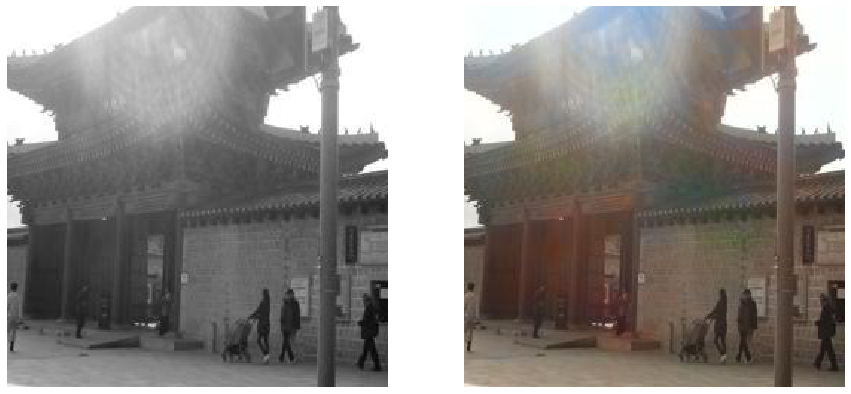

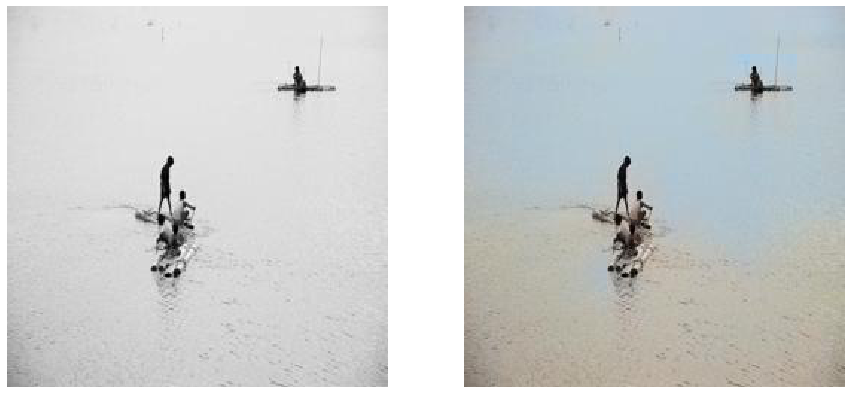

In [41]:
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-7296-epoch-0.jpg', 'outputs/gray/img-7296-epoch-0.jpg'),
               ('outputs/color/img-7297-epoch-0.jpg', 'outputs/gray/img-7297-epoch-0.jpg')]
for c, g in image_pairs:
    color = mpimg.imread(c)
    gray  = mpimg.imread(g)
    f, axarr = plt.subplots(1, 2)
    f.set_size_inches(15, 15)
    axarr[0].imshow(gray, cmap='gray')
    axarr[1].imshow(color)
    axarr[0].axis('off'), axarr[1].axis('off')
    plt.show()